#Importing Libraries and Downloading Packages
###To begin, we need to import essential libraries. The following imports handle sequence data processing, run BLAST searches from within Python, and allow for general data manipulation and visualization.

####Install Biopython: Run the command below to install Biopython, which is essential for dealing with sequence data in Python.

In [30]:
!pip install biopython

In [31]:
from Bio import SeqIO
from Bio.Blast.Applications import NcbiblastnCommandline
import os
import re
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from Bio.Blast import NCBIXML

#### Install BLAST+: BLAST+ is installed using apt-get to allow for local BLAST searches.

In [32]:
!apt-get install ncbi-blast+

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ncbi-blast+ is already the newest version (2.12.0+ds-3build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


#### Download BLAST Database: A SwissProt BLAST database is downloaded for local use with BLAST. This step is important to make sure we have a reference database to search against.


In [33]:
!wget ftp://ftp.ncbi.nlm.nih.gov/blast/db/swissprot.tar.gz
!tar -xzf swissprot.tar.gz

--2024-12-01 22:18:45--  ftp://ftp.ncbi.nlm.nih.gov/blast/db/swissprot.tar.gz
           => ‘swissprot.tar.gz.3’
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.10, 130.14.250.11, 130.14.250.12, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.10|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /blast/db ... done.
==> SIZE swissprot.tar.gz ... 217071936
==> PASV ... done.    ==> RETR swissprot.tar.gz ... done.
Length: 217071936 (207M) (unauthoritative)

swissprot.tar.gz.3  100%[===================>] 207.02M  15.9MB/s    in 23s     

2024-12-01 22:19:11 (9.01 MB/s) - ‘swissprot.tar.gz.3’ saved [217071936]



#Step 1: Parse Genomic Files (FASTA Parsing)
##Objective: Load genomic sequences from a FASTA file.

####We are using Biopython for parsing the genomic sequences in a .fasta file format. FASTA is a text-based format for representing nucleotide sequences or peptide sequences, in which base pairs or amino acids are represented using single-letter codes.

###Parse the FASTA file to read the genomic sequences:
- The function below, parse_fasta, loads genomic sequences from the given FASTA file.
- It uses SeqIO.parse() from Biopython to iterate through sequences, storing them in a dictionary where keys are sequence IDs and values are the sequences.

In [34]:
def parse_fasta(file_path):
    sequences = {}
    for record in SeqIO.parse(file_path, "fasta"):
        sequences[record.id] = str(record.seq)
    return sequences

fasta_file = "Galaxy10-[SPAdes_on_data_8_and_data_7__Contigs].fasta"
genome_sequences = parse_fasta(fasta_file)
print(genome_sequences)


{'NODE_1_length_29600_cov_2807.600616': 'GTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTCGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGATTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACACGGAACGTTCTGAAAAGAGCTATGAATTGCAGACACCTTTTGAAATTAAATTGGCAAAGAAATTTGACACCTTCAATGGGGAATGTCCAAATTTTGTATTTCCCTTAAATTCCATAAT

#Step 2: Advanced ORF Finding and Analysis
####This function, find_genes_advanced, performs more sophisticated gene prediction and analysis. It looks for ORFs with additional constraints like GC content, minimum gene length, and codon usage.

###Identify ORFs with Filters
####Arguments:
- min_length: Minimum length of the ORF.
- min_gc_content: Minimum GC content.
- start_codons and stop_codons: Used to specify codons for the beginning and end of genes.

####The function searches for ORFs based on the sequence's AT and GC content thresholds.

In [35]:
def find_genes_advanced(sequence, min_length=300, min_gc_content=0.4, start_codons=None, stop_codons=None, max_distance_between_orfs=1000, min_at_content=0.3, max_orf_overlap=50, allow_internal_stop_codons=False):
    if start_codons is None:
        start_codons = ["ATG"]
    if stop_codons is None:
        stop_codons = ["TAA", "TAG", "TGA"]

    genes = []
    sequence_length = len(sequence)
    start_positions = []

    for codon in start_codons:
        start_positions += [m.start() for m in re.finditer(codon, sequence)]
    start_positions.sort()

    for start_pos in start_positions:
        for j in range(start_pos + 3, sequence_length - 3, 3):
            codon = sequence[j:j+3]
            if codon in stop_codons:
                orf_length = j + 3 - start_pos
                if orf_length >= min_length:
                    orf_sequence = sequence[start_pos:j + 3]

                    gc_content = (orf_sequence.count('G') + orf_sequence.count('C')) / len(orf_sequence)
                    at_content = (orf_sequence.count('A') + orf_sequence.count('T')) / len(orf_sequence)

                    if gc_content >= min_gc_content and at_content >= min_at_content:
                        if not allow_internal_stop_codons:
                            internal_stops = any(orf_sequence[k:k+3] in stop_codons for k in range(3, len(orf_sequence) - 3, 3))
                            if internal_stops:
                                continue

                        genes.append((start_pos, j + 3, gc_content, at_content))
                    break

    merged_genes = []
    last_gene = None

    for gene in genes:
        if last_gene is None:
            last_gene = gene
        else:
            start, end, gc, at = gene
            last_start, last_end, last_gc, last_at = last_gene

            if start - last_end <= max_distance_between_orfs:
                if start - last_end <= max_orf_overlap:
                    merged_gene = (last_start, end, (gc + last_gc) / 2, (at + last_at) / 2)
                    last_gene = merged_gene
                else:
                    merged_genes.append(last_gene)
                    last_gene = gene
            else:
                merged_genes.append(last_gene)
                last_gene = gene

    if last_gene is not None:
        merged_genes.append(last_gene)

    return merged_genes

def run_gene_finding_on_fasta_sequences(genome_sequences):
    for seq_id, seq in genome_sequences.items():
        result = find_genes_advanced(seq, min_length=100, min_gc_content=0.35, min_at_content=0.3, max_distance_between_orfs=500, max_orf_overlap=50, allow_internal_stop_codons=True)
        print(f"Results for sequence ID: {seq_id}")
        for gene in result:
            print(f"  Start: {gene[0]}, End: {gene[1]}, GC content: {gene[2]:.2f}, AT content: {gene[3]:.2f}")

run_gene_finding_on_fasta_sequences(genome_sequences)

Results for sequence ID: NODE_1_length_29600_cov_2807.600616
  Start: 117, End: 1591, GC content: 0.42, AT content: 0.58
  Start: 1717, End: 2164, GC content: 0.38, AT content: 0.62
  Start: 2307, End: 3604, GC content: 0.36, AT content: 0.64
  Start: 3693, End: 4687, GC content: 0.36, AT content: 0.64
  Start: 4756, End: 7690, GC content: 0.36, AT content: 0.64
  Start: 7747, End: 13411, GC content: 0.48, AT content: 0.52
  Start: 13587, End: 19155, GC content: 0.38, AT content: 0.62
  Start: 19243, End: 19989, GC content: 0.38, AT content: 0.62
  Start: 20127, End: 20268, GC content: 0.35, AT content: 0.65
  Start: 20459, End: 20631, GC content: 0.36, AT content: 0.64
  Start: 20702, End: 21168, GC content: 0.38, AT content: 0.62
  Start: 21312, End: 21745, GC content: 0.37, AT content: 0.63
  Start: 21870, End: 22108, GC content: 0.37, AT content: 0.63
  Start: 22210, End: 24850, GC content: 0.36, AT content: 0.64
  Start: 24901, End: 25549, GC content: 0.44, AT content: 0.56
  Star

#Step 3: Functional Annotation (Database Searches)
####Objective: Use BLAST to search for homologous sequences and annotate the genes found in Step 2.

####The annotate_genes_local() function performs the functional annotation by:
- Extracting each ORF and saving it as a FASTA file.
- Running a BLAST search (blastx) against a protein database (e.g., SwissProt) to identify similar protein sequences.
- Extracting annotations from the BLAST results, such as the best match for each ORF.

In [36]:
def annotate_genes_local(sequence, gene_positions, blast_db, output_dir):
    annotations = []
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for idx, (start, end, gc_content, at_content) in enumerate(gene_positions):
        orf_sequence = sequence[start:end]
        orf_file = os.path.join(output_dir, f"orf_{idx}.fasta")
        with open(orf_file, "w") as f:
            f.write(f">orf_{idx}\n{orf_sequence}\n")

        blast_output_file = os.path.join(output_dir, f"orf_{idx}_blast.xml")

        blastx_cline = NcbiblastxCommandline(query=orf_file, db=blast_db, evalue=0.001, outfmt=5, out=blast_output_file)
        stdout, stderr = blastx_cline()

        with open(blast_output_file) as result_handle:
            blast_record = NCBIXML.read(result_handle)

            if blast_record.alignments:
                top_hit = blast_record.alignments[0]
                annotations.append({
                    "start": start,
                    "end": end,
                    "gc_content": gc_content,
                    "at_content": at_content,
                    "hit_title": top_hit.title,
                    "hit_length": top_hit.length,
                    "hit_accession": top_hit.accession
                })
            else:
                annotations.append({
                    "start": start,
                    "end": end,
                    "gc_content": gc_content,
                    "at_content": at_content,
                    "hit_title": "No significant match"
                })
    return annotations

In [37]:
def run_gene_finding_on_fasta_sequences(genome_sequences, blast_db, output_dir):
    for seq_id, seq in genome_sequences.items():
        result = find_genes_advanced(seq, min_length=100, min_gc_content=0.35, min_at_content=0.3, max_distance_between_orfs=500, max_orf_overlap=50, allow_internal_stop_codons=True)
        print(f"Results for sequence ID: {seq_id}")
        annotations = annotate_genes_local(seq, result, blast_db, output_dir)
        for annotation in annotations:
            print(f"  Start: {annotation['start']}, End: {annotation['end']}, GC content: {annotation['gc_content']:.2f}, AT content: {annotation['at_content']:.2f}, Annotation: {annotation['hit_title']}")

blast_db = "swissprot"
output_dir = "blast_results"
run_gene_finding_on_fasta_sequences(genome_sequences, blast_db, output_dir)


Results for sequence ID: NODE_1_length_29600_cov_2807.600616
  Start: 117, End: 1591, GC content: 0.42, AT content: 0.58, Annotation: sp|P0DTC1.1| RecName: Full=Replicase polyprotein 1a; Short=pp1a; AltName: Full=ORF1a polyprotein; Contains: RecName: Full=Host translation inhibitor nsp1; AltName: Full=Leader protein; AltName: Full=Non-structural protein 1; Short=nsp1; Contains: RecName: Full=Non-structural protein 2; Short=nsp2; AltName: Full=p65 homolog; Contains: RecName: Full=Papain-like protease nsp3; AltName: Full=Non-structural protein 3; Short=nsp3; AltName: Full=PL2-PRO; AltName: Full=Papain-like proteinase; Short=PL-PRO; Contains: RecName: Full=Non-structural protein 4; Short=nsp4; Contains: RecName: Full=3C-like proteinase nsp5; Short=3CL-PRO; Short=3CLp; AltName: Full=Main protease; Short=Mpro; AltName: Full=Non-structural protein 5; Short=nsp5; AltName: Full=SARS coronavirus main proteinase; Contains: RecName: Full=Non-structural protein 6; Short=nsp6; Contains: RecName: Fu

#Step 4: Annotation Integration
####Objective: Integrate the annotations obtained from BLAST into a consolidated data structure.

####After running the BLAST searches, all the annotation information is compiled into a CSV file for downstream analysis.

In [38]:
annotations_df = pd.DataFrame(annotations)
annotations_df.to_csv("annotations_output.csv", index=False)

#Step 5: Generate GFF Output
####Objective: Generate a GFF file to store the annotated features in a format commonly used in bioinformatics.

####The generate_gff_file() function writes the annotation details into a GFF file, which is a standard format for representing gene features.

In [39]:
def generate_gff_file(annotations, output_file):
    with open(output_file, "w") as f:
        f.write("##gff-version 3\n")
        for idx, annotation in enumerate(annotations):
            f.write(f"{annotation['start']}\tgene_finder\tgene\t{annotation['start']}\t{annotation['end']}\t.\t+\t.\tID=gene{idx};Name={annotation['hit_title']}\n")

#Step 6: Visualizations
####Objective: Visualize the ORF locations, GC content, and key BLAST annotations.

####Visualization is crucial for understanding the distribution of ORFs, their GC content, and other biological features.

- ORF Locations: A horizontal bar plot showing the positions and lengths of each ORF in the sequence.
- GC Content: A line plot depicting the GC content of each ORF.
- Key Annotations: An arrow plot showing the ORF locations with labels for key annotations extracted from BLAST hits.


Results for sequence ID: NODE_1_length_29600_cov_2807.600616


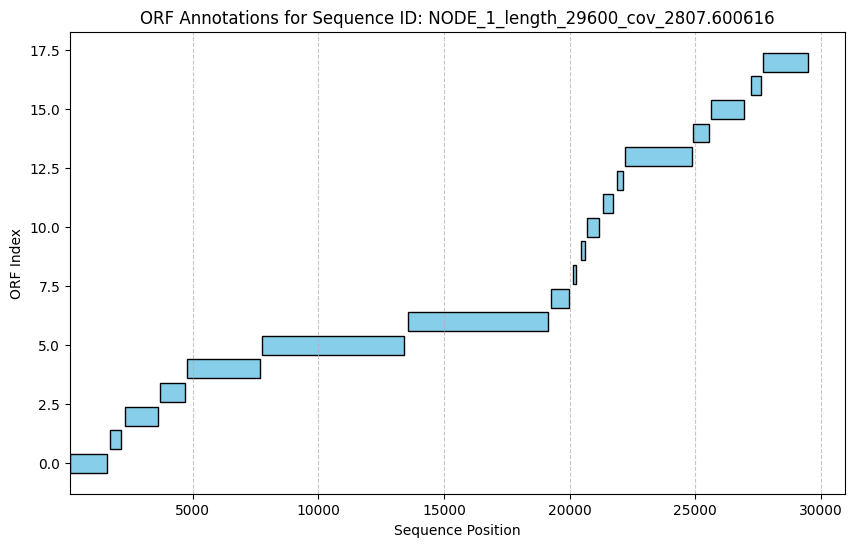

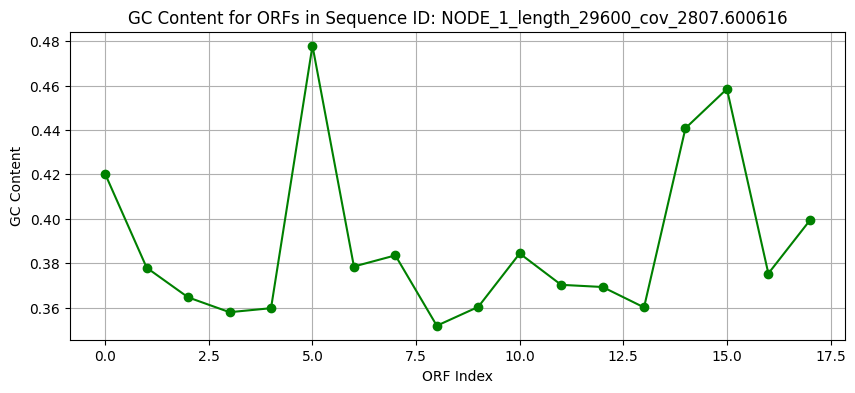

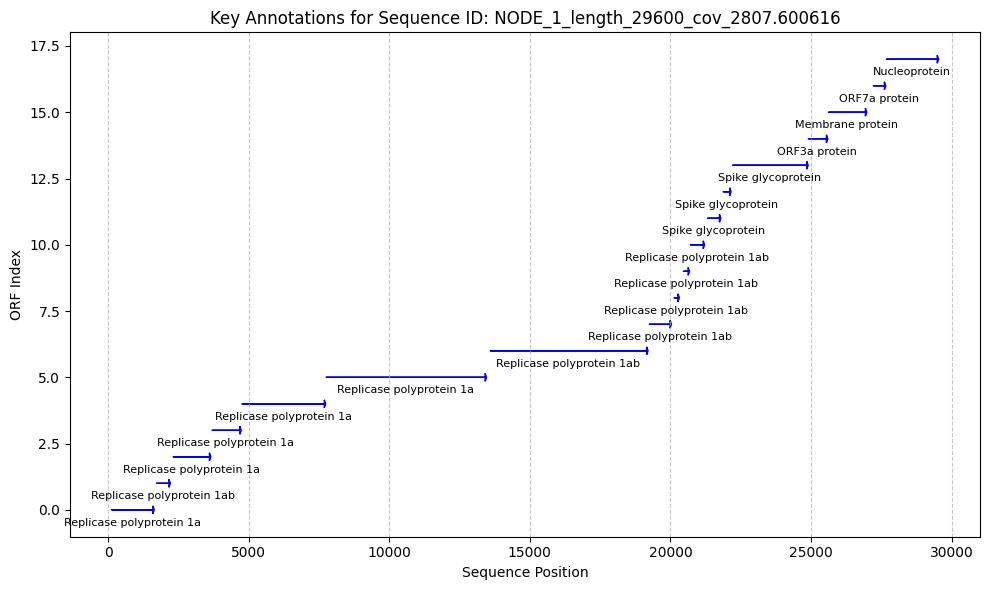

  Start: 117, End: 1591, GC content: 0.42, AT content: 0.58, Annotation: sp|P0DTC1.1| RecName: Full=Replicase polyprotein 1a; Short=pp1a; AltName: Full=ORF1a polyprotein; Contains: RecName: Full=Host translation inhibitor nsp1; AltName: Full=Leader protein; AltName: Full=Non-structural protein 1; Short=nsp1; Contains: RecName: Full=Non-structural protein 2; Short=nsp2; AltName: Full=p65 homolog; Contains: RecName: Full=Papain-like protease nsp3; AltName: Full=Non-structural protein 3; Short=nsp3; AltName: Full=PL2-PRO; AltName: Full=Papain-like proteinase; Short=PL-PRO; Contains: RecName: Full=Non-structural protein 4; Short=nsp4; Contains: RecName: Full=3C-like proteinase nsp5; Short=3CL-PRO; Short=3CLp; AltName: Full=Main protease; Short=Mpro; AltName: Full=Non-structural protein 5; Short=nsp5; AltName: Full=SARS coronavirus main proteinase; Contains: RecName: Full=Non-structural protein 6; Short=nsp6; Contains: RecName: Full=Non-structural protein 7; Short=nsp7; Contains: RecName: F

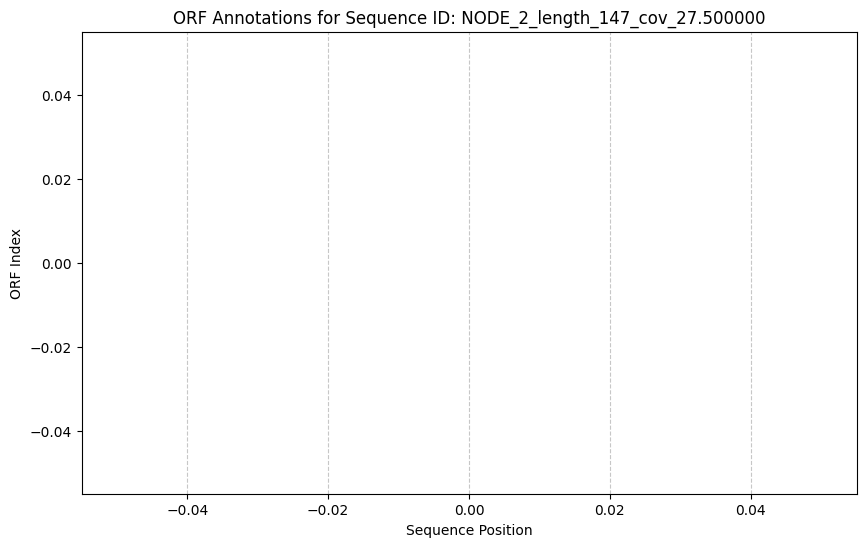

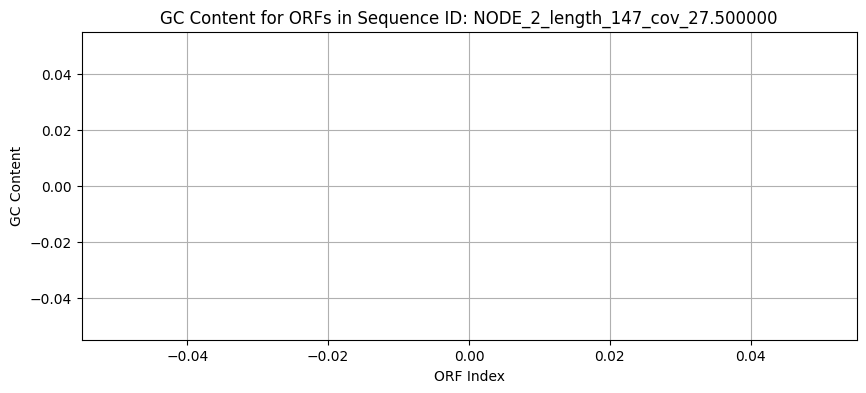

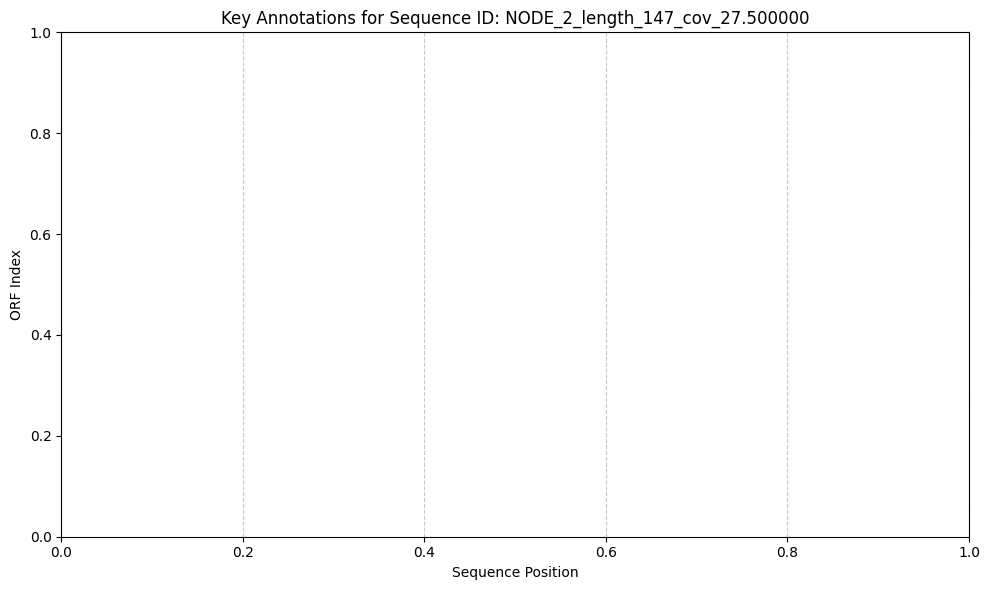

In [40]:
def visualize_annotations(annotations, seq_id):
    starts = [annotation['start'] for annotation in annotations]
    ends = [annotation['end'] for annotation in annotations]
    gc_contents = [annotation['gc_content'] for annotation in annotations]

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(annotations)), [end - start for start, end in zip(starts, ends)], left=starts, color='skyblue', edgecolor='black')
    plt.xlabel('Sequence Position')
    plt.ylabel('ORF Index')
    plt.title(f'ORF Annotations for Sequence ID: {seq_id}')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(range(len(gc_contents)), gc_contents, marker='o', linestyle='-', color='green')
    plt.xlabel('ORF Index')
    plt.ylabel('GC Content')
    plt.title(f'GC Content for ORFs in Sequence ID: {seq_id}')
    plt.grid(True)
    plt.show()

    starts = [ann['start'] for ann in annotations]
    ends = [ann['end'] for ann in annotations]

    labels = [
        re.search(r'Full=([^;]+)', ann['hit_title']).group(1)
        if re.search(r'Full=([^;]+)', ann['hit_title'])
        else 'Unknown'
        for ann in annotations
    ]

    plt.figure(figsize=(10, 6))
    for idx, (start, end, label) in enumerate(zip(starts, ends, labels)):
        plt.arrow(start, idx, end - start, 0, head_width=0.3, head_length=50, fc='blue', ec='blue')
        plt.text((start + end) / 2, idx - 0.3, label, fontsize=8, ha='center', va='top', color='black')

    plt.xlabel('Sequence Position')
    plt.ylabel('ORF Index')
    plt.title(f'Key Annotations for Sequence ID: {seq_id}')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def run_gene_finding_on_fasta_sequences(genome_sequences, blast_db, output_dir):
    for seq_id, seq in genome_sequences.items():
        result = find_genes_advanced(seq, min_length=100, min_gc_content=0.35, min_at_content=0.3, max_distance_between_orfs=500, max_orf_overlap=50, allow_internal_stop_codons=True)
        print(f"Results for sequence ID: {seq_id}")
        annotations = annotate_genes_local(seq, result, blast_db, output_dir)
        generate_gff_file(annotations, f"{seq_id}.gff")
        visualize_annotations(annotations, seq_id)
        for annotation in annotations:
            print(f"  Start: {annotation['start']}, End: {annotation['end']}, GC content: {annotation['gc_content']:.2f}, AT content: {annotation['at_content']:.2f}, Annotation: {annotation['hit_title']}")

blast_db = "swissprot"
output_dir = "blast_results"
run_gene_finding_on_fasta_sequences(genome_sequences, blast_db, output_dir)
